In [1]:
# TODO 
# REMOVE NON NEEDED VISUALISATIONS !!!!!!!

# ONLY 7 MUSCLES CLASSIFICATION WITHOUT R+L!!!!!

In [2]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks
# %pip install tqdm

In [3]:
# Imports
import os
import glob
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# import biosignalsnotebooks as bsnb
# import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from keras import Sequential
from keras.models import load_model
from tensorflow.keras.layers import *
from keras.src.layers import Reshape
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.src.callbacks import ModelCheckpoint
from keras.src.layers import GlobalAveragePooling1D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM #, PReLU 

# Weight and Biases
import wandb
# from wandb.keras import WandbCallback
from wandb.keras import WandbMetricsLogger #, WandbModelCheckpoint

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

## Creating the sEMG Signal Dataframes from the CSV files

In [4]:
# # Function to create a dataframe to store the data of every subject across all trials 
# def subject_df_creator(subject_id, muscles_of_interest):
#     trials_dfs_list = []
#     output_msg=[]
# 
#     for trial_number in tqdm(range(1, 51), desc=f"Concatenating trial Files for Subject AB{subject_id}"):
#         filename = f"5362627/AB{subject_id}/AB{subject_id}/Raw/AB{subject_id}_Circuit_0{trial_number:02d}_raw.csv"
#         if not os.path.exists(filename):  # Check if the file exists
#             output_msg.append(f"0{trial_number:02d}")
#             continue
# 
#         df_trial = pd.read_csv(filename)
#         df_trial_combined = pd.DataFrame()
# 
#         # Concatenate 'Right_' and 'Left_' values for each muscle of interest
#         for i in range(len(muscles_of_interest)):
#             df_trial_combined[muscles_of_interest[i]] = pd.concat([df_trial['Right_'+muscles_of_interest[i]], df_trial['Left_'+muscles_of_interest[i]]], ignore_index=True)
# 
#         trials_dfs_list.append(df_trial_combined)
# 
#     # Concatenate all DataFrames in the list along the rows axis
#     merged_df = pd.concat(trials_dfs_list, ignore_index=True)
#     if output_msg:
#         print(f"{len(output_msg)} Files do not exist:", output_msg)
#     return merged_df

In [5]:
# Defining important lists
subjects = ["156", "185", "186", "188", "189", "190", "191", "192", "193", "194"]
muscles = ['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF']

In [6]:
# # Creating dataframes to save subject-specific data
# df_subject_156 = subject_df_creator("156", muscles)
# df_subject_185 = subject_df_creator("185", muscles)
# df_subject_186 = subject_df_creator("186", muscles)
# df_subject_188 = subject_df_creator("188", muscles)
# df_subject_189 = subject_df_creator("189", muscles)
# df_subject_190 = subject_df_creator("190", muscles)
# df_subject_191 = subject_df_creator("191", muscles)
# df_subject_192 = subject_df_creator("192", muscles)
# df_subject_193 = subject_df_creator("193", muscles)
# df_subject_194 = subject_df_creator("194", muscles)

In [7]:
# # Saving the Dataframes into pickle objects to save time
# df_subject_156.to_pickle('pickled_dataframes/df_subject_156.pkl')
# df_subject_185.to_pickle('pickled_dataframes/df_subject_185.pkl')
# df_subject_186.to_pickle('pickled_dataframes/df_subject_186.pkl')
# df_subject_188.to_pickle('pickled_dataframes/df_subject_188.pkl')
# df_subject_189.to_pickle('pickled_dataframes/df_subject_189.pkl')
# df_subject_190.to_pickle('pickled_dataframes/df_subject_190.pkl')
# df_subject_191.to_pickle('pickled_dataframes/df_subject_191.pkl')
# df_subject_192.to_pickle('pickled_dataframes/df_subject_192.pkl')
# df_subject_193.to_pickle('pickled_dataframes/df_subject_193.pkl')
# df_subject_194.to_pickle('pickled_dataframes/df_subject_194.pkl')

In [8]:
# Loading pickle files into DataFrames
df_subject_156 = pd.read_pickle('pickled_dataframes/df_subject_156.pkl')
df_subject_185 = pd.read_pickle('pickled_dataframes/df_subject_185.pkl')
df_subject_186 = pd.read_pickle('pickled_dataframes/df_subject_186.pkl')
df_subject_188 = pd.read_pickle('pickled_dataframes/df_subject_188.pkl')
df_subject_189 = pd.read_pickle('pickled_dataframes/df_subject_189.pkl')
df_subject_190 = pd.read_pickle('pickled_dataframes/df_subject_190.pkl')
df_subject_191 = pd.read_pickle('pickled_dataframes/df_subject_191.pkl')
df_subject_192 = pd.read_pickle('pickled_dataframes/df_subject_192.pkl')
df_subject_193 = pd.read_pickle('pickled_dataframes/df_subject_193.pkl')
df_subject_194 = pd.read_pickle('pickled_dataframes/df_subject_194.pkl')

In [9]:
# Merging all the subject dataframes into one
list_of_all_subjects_dfs = [df_subject_156, df_subject_185, df_subject_186, df_subject_188, df_subject_189,
                            df_subject_190, df_subject_191, df_subject_192, df_subject_193, df_subject_194]

df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [10]:
df_all_subjects

,TA,MG,SOL,BF,ST,VL,RF
0,-0.110857,-0.078660,-0.077287,-0.073320,-0.107652,-0.075303,-0.069352
1,-0.094835,-0.069810,-0.068132,-0.071031,-0.103227,-0.072251,-0.062943
2,-0.083238,-0.055314,-0.057298,-0.064775,-0.096361,-0.067063,-0.055772
3,-0.076219,-0.051194,-0.052110,-0.059281,-0.091478,-0.066148,-0.049821
4,-0.071336,-0.048295,-0.049363,-0.058976,-0.093614,-0.064622,-0.049668
...,...,...,...,...,...,...,...
23351875,-0.089799,-0.063249,-0.095598,-0.070573,-0.103685,-0.042039,-0.072404
23351876,-0.094224,-0.061875,-0.082628,-0.072709,-0.088273,-0.052720,-0.062028
23351877,-0.093767,-0.059892,-0.076371,-0.072709,-0.078202,-0.051804,-0.055924
23351878,-0.096666,-0.061112,-0.072251,-0.075151,-0.070878,-0.055009,-0.052567


## EMG Signal Visualisation 

In [11]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=df_all_subjects.index/1000, y=df_all_subjects['TA'][60000:90000]))
# fig1.update_layout( title="sEMG Signal: Sitting Vs Contraction Bursts Vs Rest", xaxis_title="Time (s)",
#                     yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4),
#                     autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## EMG Signal Analysis

In [12]:
# Studying mean, sigma and variance of the 2 Muscles
df_analysis = pd.DataFrame()
df_analysis['Mean'] = df_all_subjects.mean()
df_analysis['Std'] = df_all_subjects.std()
df_analysis['Var'] = df_all_subjects.var()
df_analysis

,Mean,Std,Var
TA,-0.095527,0.053082,0.002818
MG,-0.067019,0.046308,0.002144
SOL,-0.078862,0.053928,0.002908
BF,-0.074807,0.034799,0.001211
ST,-0.092018,0.027390,0.000750
VL,-0.063718,0.041050,0.001685
RF,-0.064333,0.021242,0.000451


## Burst Detection

In [13]:
# # Saving the detected bursts for every muscle 
# sr = 1000 # sample rate = 1000Hz
# sl = 20 # smooth level (Size of sliding window used during the moving average process) #used to be 40
# th = 10 # threshold (To cover activation)
# 
# # Initializing lists
# detected_bursts_TA = [] ; detected_bursts_MG = [] ; detected_bursts_SOL= []
# detected_bursts_BF = [] ; detected_bursts_ST = [] ; detected_bursts_VL = []
# detected_bursts_RF = []
# 
# pbar = tqdm(total=len(muscles)*len(list_of_all_subjects_dfs), desc="All Subjects Burst Detection Progress", unit= "Muscle")
# for df_subject in list_of_all_subjects_dfs:
#     ## TA
#     detected_bursts_TA.append(bsnb.detect_emg_activations(emg_signal=df_subject['TA'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)  # Update progress bar
#     ## MG
#     detected_bursts_MG.append(bsnb.detect_emg_activations(emg_signal=df_subject['MG'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## SOL
#     detected_bursts_SOL.append(bsnb.detect_emg_activations(emg_signal=df_subject['SOL'], sample_rate=sr, smooth_level=sl,
#                                                            threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## BF
#     detected_bursts_BF.append(bsnb.detect_emg_activations(emg_signal=df_subject['BF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## ST
#     detected_bursts_ST.append(bsnb.detect_emg_activations(emg_signal=df_subject['ST'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## VL
#     detected_bursts_VL.append(bsnb.detect_emg_activations(emg_signal=df_subject['VL'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)
#     ## RF
#     detected_bursts_RF.append(bsnb.detect_emg_activations(emg_signal=df_subject['RF'], sample_rate=sr, smooth_level=sl,
#                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
#     pbar.update(1)

In [14]:
# # Creating the pickles to save the burst detection results (saves 29 minutes)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'wb') as f: pickle.dump(detected_bursts_TA, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'wb') as f: pickle.dump(detected_bursts_MG, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','wb') as f: pickle.dump(detected_bursts_SOL,f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'wb') as f: pickle.dump(detected_bursts_BF, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'wb') as f: pickle.dump(detected_bursts_ST, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'wb') as f: pickle.dump(detected_bursts_VL, f)
# with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'wb') as f: pickle.dump(detected_bursts_RF, f)

In [15]:
# Loading the pickles
pbar = tqdm(total=len(muscles), desc="Burst Detection Loading Progress", unit= "Muscle")
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_TA.pkl', 'rb') as f: detected_bursts_TA = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_MG.pkl', 'rb') as f: detected_bursts_MG = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_SOL.pkl','rb') as f: detected_bursts_SOL= pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_BF.pkl', 'rb') as f: detected_bursts_BF = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_ST.pkl', 'rb') as f: detected_bursts_ST = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_VL.pkl', 'rb') as f: detected_bursts_VL = pickle.load(f)
pbar.update(1)
with open('pickled_detected_bursts/7_muscles_all_subjects_detected_bursts_RF.pkl', 'rb') as f: detected_bursts_RF = pickle.load(f)
pbar.update(1)

Burst Detection Loading Progress:   0%|          | 0/7 [00:00<?, ?Muscle/s]

True

In [16]:
# pd.DataFrame(detected_bursts_SOL[:][:10]).transpose()

## Detected Bursts Visualisation

In [17]:
# # Visualising the EMG Burst Detection for SOL
# plot_duration = 40000 # time in milliseconds
# bsnb.detect_emg_activations(emg_signal = df_all_subjects['SOL'][:plot_duration], sample_rate = sr, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)
# print('')

In [18]:
# # Visualizing First Activations -> SEE CAPTURED WINDOW WITH RESPECT OF IDENTIFIED ACTIVATION
# duration = 8000
# shift = 2000
# number_bursts_to_plot = 1
# 
# plt.rcParams["figure.figsize"] = (10,5)
# fig = plt.figure()
# 
# plt.plot(df_all_subjects['TA'][:duration], color="cornflowerblue")
# for i in range(number_bursts_to_plot): # Plot first N bursts
#     plt.axvline(detected_bursts_TA[0][i]*1000,color='red', label="Detected Burst Region") # ONSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[1][i]*1000,color='red') # OFFSET VERTICAL LINE
#     plt.axvline(detected_bursts_TA[0][i]*1000+400,color='black', label="Onset Window (300ms)") # ONSET VERTICAL LINE CORRECTED (START WINDOW)
#     plt.axvline(detected_bursts_TA[0][i]*1000-100,color='black') # VERTICAL LINE (END WINDOW)
#     
# plt.legend(loc="upper left")
# plt.xlim(shift,duration)
# plt.grid()
# plt.xlabel('Time (ms)', fontsize=10)
# plt.ylabel('sEMG Intensity (V)', fontsize=10)
# 
# # plt.savefig("Window.png")

In [19]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x = df_all_subjects.index/1000 , y=df_all_subjects['Left_TA'][:10000]))
# 
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detected burst and corrected onset window",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# fig1.add_vrect(x0=detected_bursts_TA[0][0], x1=detected_bursts_left_TA[1][0], row="all", col=1,
#                annotation_text="Detected Burst", annotation_position="top right", fillcolor="gray",
#                opacity=0.25, line_width=0)
# 
# fig1.add_vline(x=detected_bursts_left_TA[0][0]+0.4,line_width=1.5, line_dash="dot", line_color="red")
# fig1.add_vline(x=detected_bursts_left_TA[0][0]-0.1,line_width=1.5, line_dash="dot", line_color="red",
#                annotation_text="Onset Window",annotation_position="bottom right")
# 
# # fig1.update_xaxes(range=[7.5, 20000/1000])
# # fig1.update_yaxes(range=[-2, 2])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

In [20]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x= df_all_subjects.index/1000, y=df_all_subjects['TA']))
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detection of Activation Bursts",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)",
#                    margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# for i in range(len(detected_bursts_TA[0])):
#     fig1.add_vrect(x0=detected_bursts_TA[0][i], x1=detected_bursts_TA[1][i], row="all", col=1,
#                    annotation_text="Detected Burst", annotation_position="top right",
#                    fillcolor="black", opacity=0.25, line_width=0)
# 
# # fig1.update_xaxes(range=[30, 60])
# fig1.update_layout(autosize=False, width=800, height=301)
# # plotting
# fig1.show()

## Detected Bursts Analysis 

### Number of Detected Bursts

In [21]:
# Defining Variables to store the total number of bursts for every muscle 
tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL= []; tot_bursts_BF = []
tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
burst_count_list_for_printing = []

# Calculating the total number of bursts per muscle
for subject_idx, subject in enumerate(subjects):
    tot_bursts_TA.append(len(detected_bursts_TA[subject_idx][0]))
    tot_bursts_MG.append(len(detected_bursts_MG[subject_idx][0]))
    tot_bursts_SOL.append(len(detected_bursts_SOL[subject_idx][0]))
    tot_bursts_BF.append(len(detected_bursts_BF[subject_idx][0]))
    tot_bursts_ST.append(len(detected_bursts_ST[subject_idx][0]))
    tot_bursts_VL.append(len(detected_bursts_VL[subject_idx][0]))
    tot_bursts_RF.append(len(detected_bursts_RF[subject_idx][0]))
    # Saving the results in a list for fancy printing
    burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
                                          tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
                                          tot_bursts_RF[subject_idx]])

# Adding the total row to the printing
burst_count_list_for_printing.append([])
burst_count_list_for_printing.append(['---'])
burst_count_list_for_printing.append(['Total Sum', sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)])

# Printing the table
print("Number of Muscle Bursts Per Subject Per Muscle:\n")
headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts"]
print(tabulate(burst_count_list_for_printing, headers=headers))

Number of Muscle Bursts Per Subject Per Muscle:

Subject      TA Bursts    MG Bursts    SOL Bursts    BF Bursts    ST Bursts    VL Bursts    RF Bursts
---------  -----------  -----------  ------------  -----------  -----------  -----------  -----------
156                452          760           296          815           40          214          156
185                399          948           832          742          736         1132         1117
186                398          729           695          554          739          650          475
188                 16           31           166           15            5           84            3
189                719          973          1001          301          953          799          469
190                450          851           737          477          878          432          761
191                205          915           500          555          694          733          111
192                100          6

### Longest Detected Bursts

In [22]:
# Lists to store longest burst per muscle for all subjects
longest_bursts_TA = []; longest_bursts_MG = []; longest_bursts_SOL= []
longest_bursts_BF = []; longest_bursts_ST = []; longest_bursts_VL = []
longest_bursts_RF = []
longest_burst_list_for_printing = []

# Calculating the longest burst per muscle
for subject_idx, subject in enumerate(subjects):
    longest_bursts_TA.append(max(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0])))
    longest_bursts_MG.append(max(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0])))
    longest_bursts_SOL.append(max(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0])))
    longest_bursts_BF.append(max(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0])))
    longest_bursts_ST.append(max(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0])))
    longest_bursts_VL.append(max(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0])))
    longest_bursts_RF.append(max(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0])))
    # Saving the results in a list for printing
    longest_burst_list_for_printing.append([subject, longest_bursts_TA[subject_idx],longest_bursts_MG[subject_idx],
                                            longest_bursts_SOL[subject_idx],longest_bursts_BF[subject_idx],
                                            longest_bursts_ST[subject_idx],longest_bursts_VL[subject_idx],
                                            longest_bursts_RF[subject_idx]])

# Adding the total row to the printing
longest_burst_list_for_printing.append([])
longest_burst_list_for_printing.append(['---'])
longest_burst_list_for_printing.append(['Longest Burst', max(longest_bursts_TA), max(longest_bursts_MG),
                                        max(longest_bursts_SOL), max(longest_bursts_BF),
                                        max(longest_bursts_ST), max(longest_bursts_VL),
                                        max(longest_bursts_RF)])

# Printing the table
print("Longest Burst Per Subject Per Muscle:\n")
headers = ["Subject", "TA (s)", "MG (s)", "SOL (s)", "BF (s)", "ST (s)", "VL (s)", "RF (s)"]
print(tabulate(longest_burst_list_for_printing, headers=headers))

Longest Burst Per Subject Per Muscle:

Subject          TA (s)    MG (s)    SOL (s)    BF (s)    ST (s)    VL (s)    RF (s)
-------------  --------  --------  ---------  --------  --------  --------  --------
156               2.439     2.515      1.666     6.978     1.549     1.3       1.136
185               2.144     1.145      2.081     1.206     2.13      6.104     7.858
186               3.562     1.2        6.879     1.339     1.393     2.755    14.415
188               0.498     0.484      0.487     2.926     0.482     0.728     0.484
189               1.935     1.033      1.054     1.635     1.401     1.337     8.304
190               2.8       1.049      8.063    27.161    15.564     0.868    23.222
191               1.386     1.741     12.86      2.449     3.614    16.882     1.026
192               1.32      0.857      6.178    42.035     1.495    42.095   350.68
193               1.811     0.487      0.761     0.754     2.673     1.18      0.747
194               1.326    

### Average Detected Bursts Lengths

In [23]:
# Lists to store average burst length per muscle for all subjects
average_burst_lengths_TA = [] ; average_burst_lengths_MG = [] ; average_burst_lengths_SOL= []
average_burst_lengths_BF = [] ; average_burst_lengths_ST = [] ; average_burst_lengths_VL = []
average_burst_lengths_RF = []
avg_burst_len_list_for_printing = []


# Calculating average burst length per muscle
for subject_idx, subject in enumerate(subjects):
    average_burst_lengths_TA.append(np.mean(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0])))
    average_burst_lengths_MG.append(np.mean(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0])))
    average_burst_lengths_SOL.append(np.mean(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0])))
    average_burst_lengths_BF.append(np.mean(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0])))
    average_burst_lengths_ST.append(np.mean(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0])))
    average_burst_lengths_VL.append(np.mean(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0])))
    average_burst_lengths_RF.append(np.mean(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0])))
    # Saving the results in a list for fancy printing
    avg_burst_len_list_for_printing.append([subject,
                                            round(np.mean(average_burst_lengths_TA[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_MG[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_SOL[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_BF[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_ST[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_VL[subject_idx]), 3),
                                            round(np.mean(average_burst_lengths_RF[subject_idx]), 3)])

# Adding the total row to the printing
avg_burst_len_list_for_printing.append([])
avg_burst_len_list_for_printing.append(['---'])
avg_burst_len_list_for_printing.append(['Avg. Len', round(np.mean(average_burst_lengths_TA), 3), round(np.mean(average_burst_lengths_MG), 3),
                                        round(np.mean(average_burst_lengths_SOL), 3), round(np.mean(average_burst_lengths_BF), 3),
                                        round(np.mean(average_burst_lengths_ST), 3), round(np.mean(average_burst_lengths_VL), 3),
                                        round(np.mean(average_burst_lengths_RF), 3)])

# Printing the table
print("Average Burst Length Per Subject Per Muscle:\n")
headers = ["Subject", "TA Avg.Len (s)", "MG Avg.Len (s)", "SOL Avg.Len (s)", "BF Avg.Len (s)", "ST Avg.Len (s)", "VL Avg.Len (s)", "RF Avg.Len (s)"]
print(tabulate(avg_burst_len_list_for_printing, headers=headers))

Average Burst Length Per Subject Per Muscle:

Subject      TA Avg.Len (s)    MG Avg.Len (s)    SOL Avg.Len (s)    BF Avg.Len (s)    ST Avg.Len (s)    VL Avg.Len (s)    RF Avg.Len (s)
---------  ----------------  ----------------  -----------------  ----------------  ----------------  ----------------  ----------------
156                   0.461             0.474              0.381             0.662             0.279             0.515             0.438
185                   0.469             0.459              0.499             0.439             0.423             0.678             0.668
186                   0.369             0.44               0.62              0.433             0.378             0.496             1.797
188                   0.249             0.24               0.346             0.673             0.401             0.283             0.48
189                   0.474             0.459              0.443             0.378             0.411             0.522             0.

### Histogram: Detected Bursts Lengths

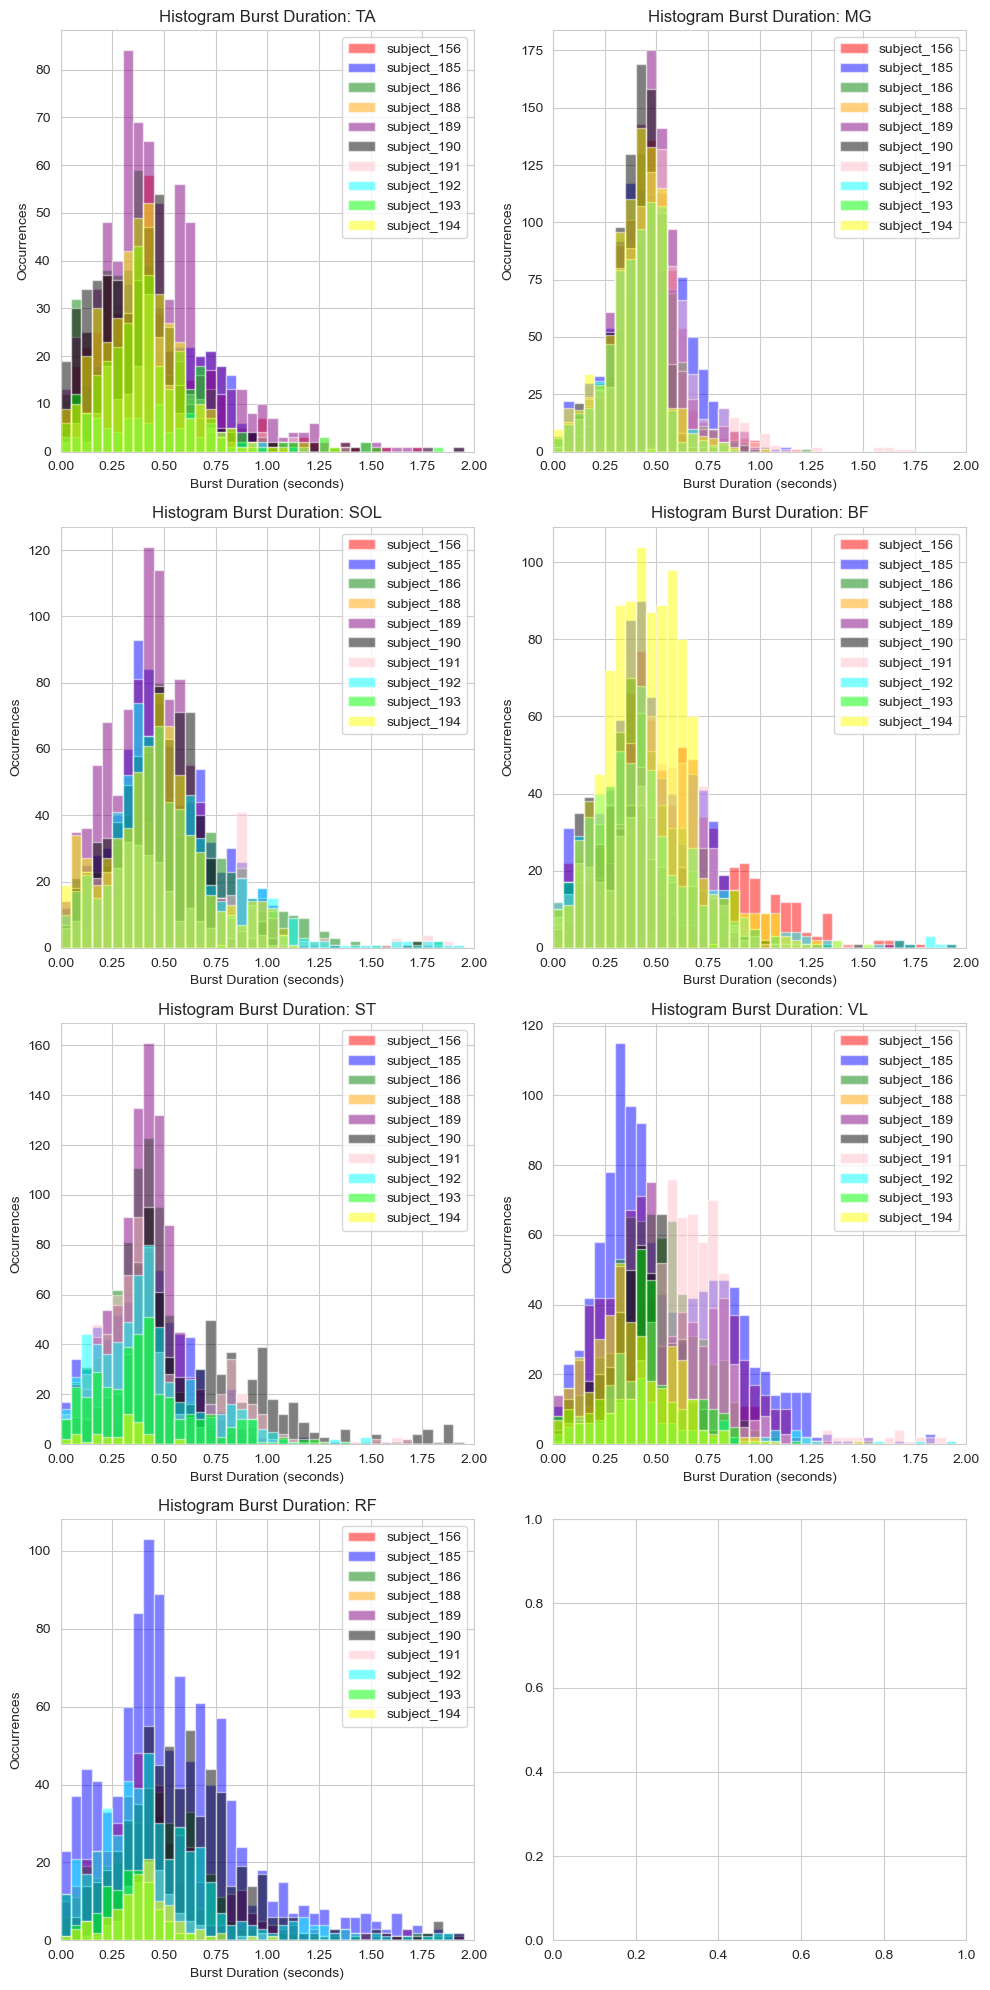

In [24]:
# Adjust subplot indexing
f, a = plt.subplots(4, 2)
f.set_size_inches(10, 20)
a = a.ravel()
bin_edges = np.arange(start=0, stop=2, step=0.05)  # Example for bins of width 0.05
colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan', 'lime', 'yellow']

for subject_idx, subject in enumerate(subjects):
    subject = "subject_" + subject
    a[0].hist(np.array(detected_bursts_TA[subject_idx][1])-np.array(detected_bursts_TA[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[1].hist(np.array(detected_bursts_MG[subject_idx][1])-np.array(detected_bursts_MG[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[2].hist(np.array(detected_bursts_SOL[subject_idx][1])-np.array(detected_bursts_SOL[subject_idx][0]),bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[3].hist(np.array(detected_bursts_BF[subject_idx][1])-np.array(detected_bursts_BF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[4].hist(np.array(detected_bursts_ST[subject_idx][1])-np.array(detected_bursts_ST[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[5].hist(np.array(detected_bursts_VL[subject_idx][1])-np.array(detected_bursts_VL[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])
    a[6].hist(np.array(detected_bursts_RF[subject_idx][1])-np.array(detected_bursts_RF[subject_idx][0]), bins=bin_edges, alpha=0.5, label=subject, color=colors[subject_idx])

# Set legends, titles, and labels for each subplot
for muscle_idx, muscle in enumerate(muscles):
    a[muscle_idx].legend(loc='upper right')
    a[muscle_idx].set_title('Histogram Burst Duration: ' + muscle)
    a[muscle_idx].set_xlabel("Burst Duration (seconds)")
    a[muscle_idx].set_ylabel("Occurrences")
    a[muscle_idx].set_xlim([0, 2])  # Remove to see how bad the burst detection is 

plt.tight_layout()
plt.show()

## Leave one out: Separating a Subject

In [25]:
leave_one_out = 2 # Specify which one to leave out (from 0 to 9)

In [26]:
# # Saving the LOO Bursts
# loo_detected_bursts_TA = [detected_bursts_TA.pop(leave_one_out)]
# loo_detected_bursts_MG = [detected_bursts_MG.pop(leave_one_out)]
# loo_detected_bursts_SOL= [detected_bursts_SOL.pop(leave_one_out)]
# loo_detected_bursts_BF = [detected_bursts_BF.pop(leave_one_out)]
# loo_detected_bursts_ST = [detected_bursts_ST.pop(leave_one_out)]
# loo_detected_bursts_VL = [detected_bursts_VL.pop(leave_one_out)]
# loo_detected_bursts_RF = [detected_bursts_RF.pop(leave_one_out)]

In [27]:
# # Saving the LOO EMG signal
# loo_emg_signal_TA  = list(list_of_all_subjects_dfs[leave_one_out]['TA'])
# loo_emg_signal_MG  = list(list_of_all_subjects_dfs[leave_one_out]['MG'])
# loo_emg_signal_SOL = list(list_of_all_subjects_dfs[leave_one_out]['SOL'])
# loo_emg_signal_BF  = list(list_of_all_subjects_dfs[leave_one_out]['BF'])
# loo_emg_signal_ST  = list(list_of_all_subjects_dfs[leave_one_out]['ST'])
# loo_emg_signal_VL  = list(list_of_all_subjects_dfs[leave_one_out]['VL'])
# loo_emg_signal_RF  = list(list_of_all_subjects_dfs[leave_one_out]['RF'])

In [28]:
# # Removing the LOO from the training
# del subjects[leave_one_out]
# del list_of_all_subjects_dfs[leave_one_out]
# df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [29]:
# # Verifying the LOO process
# print(f"Subject AB{subjects[leave_one_out]} was excluded from the training!\n"
#       f"{len(list_of_all_subjects_dfs)} subjects remaining for training!")

# Extracting Bursts

### Method: Preserving Onset and Window = 300ms

In [30]:
# def extract_burst_windows(muscle_emg_signal, onset_list, window_size, left_shift_value, muscle_name):
#     sampling_rate = 1000
#     all_subjects_burst_samples = []
#     for subject_index in tqdm(range(len(onset_list)), desc=f"Extracting Bursts for {muscle_name}"):
#         current_subject_bursts = []
#         ii = -1
#         for onset in onset_list[subject_index][0]:
#             ii += 1
#             onset_ms = int(onset * sampling_rate) - left_shift_value
#             current_sample_window = []
#             if onset != onset_list[subject_index][0][-1]:
#                 if (onset_ms + window_size) < (onset_list[subject_index][0][ii + 1] * 1000):
#                     for time_step in range(window_size):
#                         current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
#             else:
#                 for time_step in range(window_size):
#                     current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
# 
#             if current_sample_window:
#                 current_sample_window -= np.mean(current_sample_window)
#                 current_subject_bursts.append(current_sample_window)
#         all_subjects_burst_samples.append(current_subject_bursts)
#     return all_subjects_burst_samples

In [31]:
window = 300 # in ms (total window size)
left_shift = 100 # in ms (left shift from detected onset). See detected onset on the vertical red lines in the plots above
# 
# fixed_bursts_TA = extract_burst_windows(df_all_subjects['TA'], detected_bursts_TA, window, left_shift, 'TA')
# fixed_bursts_MG = extract_burst_windows(df_all_subjects['MG'], detected_bursts_MG, window, left_shift, 'MG')
# fixed_bursts_SOL= extract_burst_windows(df_all_subjects['SOL'],detected_bursts_SOL,window, left_shift, 'SOL')
# fixed_bursts_BF = extract_burst_windows(df_all_subjects['BF'], detected_bursts_BF, window, left_shift, 'BF')
# fixed_bursts_ST = extract_burst_windows(df_all_subjects['ST'], detected_bursts_ST, window, left_shift, 'ST')
# fixed_bursts_VL = extract_burst_windows(df_all_subjects['VL'], detected_bursts_VL, window, left_shift, 'VL')
# fixed_bursts_RF = extract_burst_windows(df_all_subjects['RF'], detected_bursts_RF, window, left_shift, 'RF')

In [32]:
# # Defining Variables to store the total number of bursts for every muscle 
# tot_bursts_TA = []; tot_bursts_MG = []; tot_bursts_SOL= []; tot_bursts_BF = []
# tot_bursts_ST = []; tot_bursts_VL = []; tot_bursts_RF = []
# burst_count_list_for_printing = []
# 
# # Calculating the total number of bursts per muscle
# for subject_idx, subject in enumerate(subjects):
#     tot_bursts_TA.append(len(fixed_bursts_TA[subject_idx]))
#     tot_bursts_MG.append(len(fixed_bursts_MG[subject_idx]))
#     tot_bursts_SOL.append(len(fixed_bursts_SOL[subject_idx]))
#     tot_bursts_BF.append(len(fixed_bursts_BF[subject_idx]))
#     tot_bursts_ST.append(len(fixed_bursts_ST[subject_idx]))
#     tot_bursts_VL.append(len(fixed_bursts_VL[subject_idx]))
#     tot_bursts_RF.append(len(fixed_bursts_RF[subject_idx]))
#     # Saving the results in a list for fancy printing
#     burst_count_list_for_printing.append([subject, tot_bursts_TA[subject_idx], tot_bursts_MG[subject_idx], tot_bursts_SOL[subject_idx],
#                                           tot_bursts_BF[subject_idx], tot_bursts_ST[subject_idx], tot_bursts_VL[subject_idx],
#                                           tot_bursts_RF[subject_idx]])
# 
# # Adding the total row to the printing
# burst_count_list_for_printing.append([])
# burst_count_list_for_printing.append(['---'])
# burst_count_list_for_printing.append(['Total Sum', sum(tot_bursts_TA), sum(tot_bursts_MG), sum(tot_bursts_SOL), sum(tot_bursts_BF), sum(tot_bursts_ST), sum(tot_bursts_VL), sum(tot_bursts_RF)])
# 
# # Printing the table
# print("Number of Muscle Bursts Per Subject Per Muscle:\n")
# headers = ["Subject", "TA Bursts", "MG Bursts", "SOL Bursts", "BF Bursts", "ST Bursts", "VL Bursts", "RF Bursts"]
# print(tabulate(burst_count_list_for_printing, headers=headers))

In [33]:
# # Extracting the LOO 300-fixed bursts
# loo_fixed_bursts_TA = extract_burst_windows(loo_emg_signal_TA, loo_detected_bursts_TA, window, left_shift, 'Leave one Out: TA')[0]
# loo_fixed_bursts_MG = extract_burst_windows(loo_emg_signal_MG, loo_detected_bursts_MG, window, left_shift, 'Leave one Out: MG')[0]
# loo_fixed_bursts_SOL= extract_burst_windows(loo_emg_signal_SOL,loo_detected_bursts_SOL,window, left_shift, 'Leave one Out: SOL')[0]
# loo_fixed_bursts_BF = extract_burst_windows(loo_emg_signal_BF, loo_detected_bursts_BF, window, left_shift, 'Leave one Out: BF')[0]
# loo_fixed_bursts_ST = extract_burst_windows(loo_emg_signal_ST, loo_detected_bursts_ST, window, left_shift, 'Leave one Out: ST')[0]
# loo_fixed_bursts_VL = extract_burst_windows(loo_emg_signal_VL, loo_detected_bursts_VL, window, left_shift, 'Leave one Out: VL')[0]
# loo_fixed_bursts_RF = extract_burst_windows(loo_emg_signal_RF, loo_detected_bursts_RF, window, left_shift, 'Leave one Out: RF')[0]

In [34]:
# loo_burst_count_list_for_printing = [["Leave-One-Out", len(loo_fixed_bursts_TA), len(loo_fixed_bursts_MG), len(loo_fixed_bursts_SOL), len(loo_fixed_bursts_BF), len(loo_fixed_bursts_ST), len(loo_fixed_bursts_VL), len(loo_fixed_bursts_RF)]]
# 
# # Printing the table
# print("Number of Muscle Bursts of the Leave-One-Out Subject:\n")
# headers = ["Subject", "TA", "MG", "SOL", "BF", "ST", "VL", "RF"]
# print(tabulate(loo_burst_count_list_for_printing, headers=headers))

## Saving Leave One Out as TFRecord

In [35]:
# loo_emg_series_complete = [loo_fixed_bursts_TA, loo_fixed_bursts_MG, loo_fixed_bursts_SOL,
#                            loo_fixed_bursts_BF, loo_fixed_bursts_ST, loo_fixed_bursts_VL,
#                            loo_fixed_bursts_RF]
# 
# muscle_groups = len(loo_emg_series_complete)
# 
# with tf.io.TFRecordWriter('tfrecords/leave_one_out.tfrecord') as tfrecord:
#     for emg_muscle in tqdm(range(muscle_groups), desc="Extracting dataset to TFRecords"):
#         for sample in loo_emg_series_complete[emg_muscle]:
#             # Prepare the features for TFRecord
#             features = {
#                 'label': tf.train.Feature(float_list=tf.train.FloatList(value=tf.keras.utils.to_categorical(emg_muscle, 7))),
#                 'feature': tf.train.Feature(float_list=tf.train.FloatList(value=sample))
#             }
#             example = tf.train.Example(features=tf.train.Features(feature=features))
#             tfrecord.write(example.SerializeToString())

In [36]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
    count = 0
    if tf.executing_eagerly():
        # TF v2 or v1 in eager mode
        for _ in ds:
            count = count+1
    else:
        # TF v1 in non-eager mode
        iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
        next_batch = iterator.get_next()
        with tf.compat.v1.Session() as sess:
            try:
                while True:
                    sess.run(next_batch)
                    count = count+1
            except tf.errors.OutOfRangeError:
                pass
    return count

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

In [38]:
def loo_read_tfrecord(serialized_example):
    tfrecord_format = (
        {
            'label': tf.io.FixedLenFeature([7], tf.float32),  # MUSCLE LABEL: Adjusted for one-hot encoded labels
            'feature': tf.io.FixedLenFeature([window], tf.float32),  # sEMG VALUE: Adjusted for features
        }
    )
    example = tf.io.parse_single_example(serialized_example, tfrecord_format)
    f = tf.reshape(example['feature'], [window, 1])  # Reshape if needed, here it's kept for consistency
    f.set_shape([window, 1])
    return f, example['label']

def loo_get_dataset(tf_record_name):
    dataset = tf.data.TFRecordDataset(tf_record_name)
    dataset = dataset.map(loo_read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset_samples = countRecords(dataset)
    dataset = dataset.shuffle(dataset_samples)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [39]:
loo_dataset = loo_get_dataset('tfrecords/leave_one_out.tfrecord')

In [40]:
for feature, label in loo_dataset:
    print(f'label={label.shape}, feature={feature.shape}')

label=(1024, 7), feature=(1024, 300, 1)
label=(1024, 7), feature=(1024, 300, 1)
label=(1024, 7), feature=(1024, 300, 1)
label=(1024, 7), feature=(1024, 300, 1)
label=(120, 7), feature=(120, 300, 1)


# TFRecords: Storing Training and Validation Datasets in Tensorflow Records

Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb#scrollTo=_e3g9ExathXP

## Write TFRecords

In [41]:
# def _float_feature(value):
#     """Returns a float_list from a float / double."""
#     return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
# 
# def _int64_feature(value):
#     """Returns an int64_list from a bool / enum / int / uint."""
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
# 
# def extract_burst_windows_tfrecord(emg_series_complete, onset_lists, window_size, left_shift_value):
#     # Ensure unique file names for parallel processing or repeated calls
#     file_name = 'tfrecords/all_dataset.tfrecord'
#     with tf.io.TFRecordWriter(file_name) as tfrecord:
#         for muscle_index in tqdm(range(len(emg_series_complete)), desc="Extracting dataset to TFRecords (Fixed Window)"):
#             for subject_index in range(len(onset_lists[muscle_index])):
#                 burst_count = 0
#                 ii = -1
#                 for onset in onset_lists[muscle_index][subject_index][0]:
#                     ii += 1
#                     onset_ms = int(onset * 1000) - left_shift_value
#                     current_sample_window = []
#                     if onset != onset_lists[muscle_index][subject_index][0][-1]:
#                         if (onset_ms + window_size) < (onset_lists[muscle_index][subject_index][0][ii + 1] * 1000):
#                             burst_count = burst_count + 1
#                             for time_step in range(window_size):
#                                 current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
#                     else:
#                         burst_count = burst_count + 1
#                         for time_step in range(window_size):
#                             current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
# 
#                     if current_sample_window:
#                         current_sample_window -= np.mean(current_sample_window)
#                         # Convert your sample and label to appropriate tf.train.Feature formats
#                         features = {
#                             'label': _int64_feature(muscle_index),
#                             'feature': tf.train.Feature(float_list=tf.train.FloatList(value=current_sample_window)),
#                             'subject': _int64_feature(subject_index + 1),
#                             'burst': _int64_feature(burst_count)
#                         }
#                         example = tf.train.Example(features=tf.train.Features(feature=features))
#                         tfrecord.write(example.SerializeToString())
#     return file_name

In [42]:
# # .....
# emg_series_tot = [df_all_subjects['TA'], df_all_subjects['MG'], df_all_subjects['SOL'],
#                   df_all_subjects['BF'], df_all_subjects['ST'], df_all_subjects['VL'],
#                   df_all_subjects['RF']]
# 
# detected_bursts_tot = [detected_bursts_TA, detected_bursts_MG, detected_bursts_SOL,
#                        detected_bursts_BF, detected_bursts_ST, detected_bursts_VL,
#                        detected_bursts_RF]
# # Extracting bursts
# extract_burst_windows_tfrecord(emg_series_tot, detected_bursts_tot,  window, left_shift)

## Read TFRecords

In [43]:
# def map_fn(serialized_example):
#     features = {
#         'label': tf.io.FixedLenFeature([], tf.int64),
#         'feature': tf.io.FixedLenFeature([window], tf.float32),
#         'subject': tf.io.FixedLenFeature([], tf.int64),
#         'burst':  tf.io.FixedLenFeature([], tf.int64)
#     }
#     example = tf.io.parse_single_example(serialized_example, features)
#     return example['label'], example['feature'], example['subject'], example['burst']

In [44]:
# dataset = tf.data.TFRecordDataset('tfrecords/all_dataset.tfrecord')
# dataset = dataset.map(map_fn)
# 
# for label, feature, subject, burst in dataset.take(10):
#     print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

In [45]:
# def separate_dataset_per_subject_train_val(dataset, subj, train_percentage):
#     # Filtering whole dataset TFRECORDS by subjects:
#     dataset_subject = dataset.filter(lambda label,feature,subject,burst: subject==subj)
#     # Count Total Samples for each Subject Dataset
#     dataset_subject_samples = countRecords(dataset_subject)
#     # Shuffling bursts per subject
#     dataset_subject_shuffled = dataset_subject.shuffle(dataset_subject_samples)
#     # Separating Subject Training and Evaluation Datasets:
#     dataset_subject_1_train = dataset_subject_shuffled.take(int(dataset_subject_samples*train_percentage))
#     dataset_subject_1_val = dataset_subject_shuffled.skip(int(dataset_subject_samples*train_percentage)).take(dataset_subject_samples - int(dataset_subject_samples*train_percentage))
#     return dataset_subject_1_train, dataset_subject_1_val

In [46]:
# # Training/Validation Split
# train_percentage = 0.8
# dataset_subject1_train, dataset_subject1_val = separate_dataset_per_subject_train_val(dataset, 1, train_percentage)
# dataset_subject2_train, dataset_subject2_val = separate_dataset_per_subject_train_val(dataset, 2, train_percentage)
# dataset_subject3_train, dataset_subject3_val = separate_dataset_per_subject_train_val(dataset, 3, train_percentage)
# dataset_subject4_train, dataset_subject4_val = separate_dataset_per_subject_train_val(dataset, 4, train_percentage)
# dataset_subject5_train, dataset_subject5_val = separate_dataset_per_subject_train_val(dataset, 5, train_percentage)
# dataset_subject6_train, dataset_subject6_val = separate_dataset_per_subject_train_val(dataset, 6, train_percentage)
# dataset_subject7_train, dataset_subject7_val = separate_dataset_per_subject_train_val(dataset, 7, train_percentage)
# dataset_subject8_train, dataset_subject8_val = separate_dataset_per_subject_train_val(dataset, 8, train_percentage)
# dataset_subject9_train, dataset_subject9_val = separate_dataset_per_subject_train_val(dataset, 9, train_percentage)
# 
# # print(countRecords(dataset_subject2_train))
# 
# for label, feature, subject, burst in dataset_subject1_train.take(10):
#     print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

In [47]:
# # ???????
# all_subject_datasets_train = [dataset_subject1_train, dataset_subject2_train, dataset_subject3_train,
#                               dataset_subject4_train, dataset_subject5_train, dataset_subject6_train,
#                               dataset_subject7_train, dataset_subject8_train, dataset_subject9_train]
# 
# all_subject_datasets_val =   [dataset_subject1_val, dataset_subject2_val, dataset_subject3_val,
#                               dataset_subject4_val, dataset_subject5_val, dataset_subject6_val,
#                               dataset_subject7_val, dataset_subject8_val, dataset_subject9_val]

In [48]:
# # ????
# def augment_datasets(collection_datasets, tf_record_name):
#     with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
#         for d in collection_datasets:
#             for label, feature, subject, burst in d:
#                 features = {
#                     'label': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
#                     'feature': tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
#                     'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject]))),
#                     'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([burst])))
#                 }
#                 example = tf.train.Example(features=tf.train.Features(feature=features))
#                 tfrecord.write(example.SerializeToString())
#     return
# 
# def map_fn_final(serialized_example):
#     features = {
#         'label': tf.io.FixedLenFeature([], tf.int64),
#         'feature': tf.io.FixedLenFeature([window], tf.float32),
#         'subject': tf.io.FixedLenFeature([], tf.int64),
#         'burst': tf.io.FixedLenFeature([], tf.int64)
#     }
#     example = tf.io.parse_single_example(serialized_example, features)
#     return example['label'], example['feature'], example['subject'], example['burst']
# 
# def mix_and_shuffle_datasets(tf_record_name):
#     dataset = tf.data.TFRecordDataset(tf_record_name)
#     dataset = dataset.map(map_fn_final)
#     dataset_samples = countRecords(dataset)
#     dataset_final = dataset.shuffle(dataset_samples)
#     return dataset_final

In [49]:
# # ???????
# augment_datasets(all_subject_datasets_train, 'tfrecords/all_mixed_train.tfrecord')
# augment_datasets(all_subject_datasets_val, 'tfrecords/all_mixed_val.tfrecord')
# 
# dataset_final_train = mix_and_shuffle_datasets('tfrecords/all_mixed_train.tfrecord')
# dataset_final_val = mix_and_shuffle_datasets('tfrecords/all_mixed_val.tfrecord')

In [50]:
# for label, feature, subject, burst in dataset_final_train.take(20):
#     print(f'label={label}, feature={len(feature)}, subject={subject}, burst={burst}')

## Load TFRecords

In [51]:
def read_tfrecord(serialized_example, export_subject=False):
    tfrecord_format = (
        {
            'label': tf.io.FixedLenFeature([], tf.int64),
            'feature': tf.io.FixedLenFeature([window], tf.float32),
            'subject': tf.io.FixedLenFeature([], tf.int64),
            'burst':  tf.io.FixedLenFeature([], tf.int64)
        }
    )
    example = tf.io.parse_single_example(serialized_example, tfrecord_format)
    f = tf.reshape(example['feature'], [window,1])
    f.set_shape([window, 1])
    # One-hot encode the label to match the expected shape for categorical_crossentropy
    label = tf.one_hot(example['label'], depth=7)
    if export_subject:
        return f, label, example['subject']
    return f, label

def get_dataset(tf_record_name):
    # dataset = load_dataset(filename)
    dataset = tf.data.TFRecordDataset(tf_record_name)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset_samples = countRecords(dataset)
    print("Samples: ", dataset_samples)
    dataset = dataset.shuffle(dataset_samples)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [52]:
train_dataset = get_dataset('tfrecords/all_mixed_train.tfrecord')
valid_dataset = get_dataset('tfrecords/all_mixed_val.tfrecord')

Samples:  24224
Samples:  6060


## Verifying the shapes of: LOO, Training and Validation

In [53]:
for feature, label in loo_dataset:
    print(f'Loo: label={label.shape}, feature={feature.shape}')

Loo: label=(1024, 7), feature=(1024, 300, 1)
Loo: label=(1024, 7), feature=(1024, 300, 1)
Loo: label=(1024, 7), feature=(1024, 300, 1)
Loo: label=(1024, 7), feature=(1024, 300, 1)
Loo: label=(120, 7), feature=(120, 300, 1)


In [54]:
for feature, label in train_dataset:
    print(f'Train: label={label.shape}, feature={feature.shape}')

Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=(1024, 7), feature=(1024, 300, 1)
Train: label=

In [55]:
for feature, label in valid_dataset:
    print(f'Validation: label={label.shape}, feature={feature.shape}')

Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(1024, 7), feature=(1024, 300, 1)
Validation: label=(940, 7), feature=(940, 300, 1)


## Plotting Muscle Bursts

In [56]:
# # quick plot to see individual contraction bursts
# def plot_independent_bursts(label, burst_list, color):
#     n_cols = len(burst_list)  # number of subjects
#     fig, axs = plt.subplots(1, n_cols, figsize=(15, 3), dpi=150)  # Adjusted figure size
#     fig.subplots_adjust(top=0.85)  # Adjust top spacing
#     fig.suptitle(f'Contraction Bursts: {label} (300ms Fixed Length)', y=0.95)  # Adjust title position
# 
#     for j in range(n_cols):
#         axs[j].plot(burst_list[j][0], color=color)  # Assuming you want the first burst
#         axs[j].set_title(f'1st Burst of subject {j+1}', fontsize=10)
#         axs[j].set_xlabel('time (ms)', fontsize=8)
#         axs[j].set_ylabel('EMG', fontsize=8)
#         axs[j].label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots.
# 
#     plt.tight_layout(pad=2.0, w_pad=0.5)  # Dynamically adjust layout
#     plt.show()
# 
# plot_independent_bursts("TA", fixed_bursts_TA, "cornflowerblue")
# plot_independent_bursts("MG", fixed_bursts_MG, "orange")
# plot_independent_bursts("SOL",fixed_bursts_SOL,"red")
# plot_independent_bursts("BF", fixed_bursts_BF, "green")
# plot_independent_bursts("ST", fixed_bursts_ST, "orange")
# plot_independent_bursts("VL", fixed_bursts_VL, "cyan")
# plot_independent_bursts("RF", fixed_bursts_RF, "brown")

# Hybrid CNN-LSTM Model Implementation

In [57]:
# Parameters
# epochs = 300 # For full performance test, seems okay 
epochs = 150 # For quick performance testing
lr = 0.01
scheduler = ReduceLROnPlateau(factor=0.1, patience=15, min_lr=0.0001)  # Adjust patience as needed

## CNN Layer 1
conv1D_1 = [32,5,1]  # number_filters,kernel_size and strides 
# conv1D_1 = [64,3,1]  # number_filters,kernel_size and strides 
dropout_1= 0.3      # Dropout %
pool1D_1 = [2,2]     # pool_size and strides
## CNN Layer 2
conv1D_2 = [64,7,1]  # number_filters,kernel_size and strides
# conv1D_2 = [96,5,1]  # number_filters,kernel_size and strides
dropout_2= 0.3      # Dropout %
pool1D_2 = [2,2]     # pool_size and strides
## CNN Layer 3
conv1D_3 = [128,9,1] # number_filters,kernel_size and strides
# conv1D_3 = [256,7,1] # number_filters,kernel_size and strides
dropout_3= 0.3      # Dropout %
pool1D_3 = [2,2]     # pool_size and strides
# Dense 1
dense_1  = 50        # nodes ->50
dense_dropout_1 = 0.3# Dropout %
# Dense 2
dense_2 = 0          # nodes ->0
# LSTM 1             
lstm_1   = 30        # lstm blocks ->30
lstm_dropout_1 = 0.3 # Dropout %
# Dense 3
dense_3  = 15        # nodes ->15
dense_dropout_3 = 0.3# Dropout %

# Definition
model1 = Sequential()
model1.add(InputLayer((window,1))) #InputLayer(BURST_WINDOW, N_CHANNELS)

# CNN LAYER 1 (Conv1D + PReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_1[0],kernel_size=conv1D_1[1], # TODO TRY WITH HIGHER KERNEL SIZE (ODD NUMBER!)
                  strides=conv1D_1[2],padding='same', name='cnn_layer_1'))
    # model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.1))
    # model1.add(PReLU()) ##############
model1.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding='same'))
model1.add(Dropout(dropout_1))

# CNN LAYER 2 (Conv1D + PReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_2[0], kernel_size=conv1D_2[1], strides=conv1D_2[2],
                  padding='same', name='cnn_layer_2'))
    # model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.1))
    # model1.add(PReLU()) ##############
model1.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding='same'))
model1.add(Dropout(dropout_2))

# CNN LAYER 3 (Conv1D + LeakyReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_3[0], kernel_size=conv1D_3[1], strides=conv1D_3[2],
                  padding='same', name='cnn_layer_3'))
    # model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_3[0], strides=pool1D_3[1], padding='same'))
model1.add(Dropout(dropout_3))

# Global Average Pooling
model1.add(GlobalAveragePooling1D())

# Dense 3:  To integrate the Dense Layer 1 effectively after GAP, we reshape the output to make it compatible with the dense layer expectations
model1.add(Reshape((1, -1))) 
model1.add(Dense(dense_1))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(dense_dropout_1))

# LSTM LAYER 1 + Dropout
model1.add(LSTM(lstm_1, dropout=lstm_dropout_1))

# Dense 3
model1.add(Dense(dense_3)) 
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(dense_dropout_3))

# Softmax
model1.add(Dense(7, 'softmax')) # Softmax

#Summary
model1.summary()

# Loading Pretrained Weights
# model1.load_weights('w_cnn1.h5', by_name=True, skip_mismatch=False, options=None)
# model1.load_weights('w_cnn2.h5', by_name=True, skip_mismatch=False, options=None)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_layer_1 (Conv1D)            │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_2 (Conv1D)            │ (None, 150, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_3 (Conv1D)            │ (None, 75, 128)        │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 50)          │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,195 (410.92 KB)

 Trainable params: 105,195 (410.92 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Starting the wandb logging & Parameters
config = {
    "number of muscles": len(muscles),
    "number of subjects": len(list_of_all_subjects_dfs)+1,
    "leave-one-out SubjectID": leave_one_out,
    "batch_size": BATCH_SIZE,
    "learning_rate":lr,
    "epochs": epochs,
    "scheduler": "ReduceLROnPlateau",
    "optimizer": "Adam",
    
    "CNN_1": conv1D_1,
    "CNN_1_Activation": "LeakyReLU",
    "CNN_1_Pool": pool1D_1,
    "CNN_1_dropout": dropout_1,
    
    "CNN_2": conv1D_2,
    "CNN_2_Activation": "LeakyReLU",
    "CNN_2_Pool": pool1D_2,
    "CNN_2_dropout": dropout_2,
    
    "CNN_3": conv1D_3,
    "CNN_3_Activation": "LeakyReLU",
    "CNN_3_Pool": pool1D_3,
    "CNN_3_dropout": dropout_3,
    
    "dense_1": dense_1,
    "dense_1_dropout": dense_dropout_1,
    
    "lstm_1": lstm_1,
    "lstm_1_dropout": lstm_dropout_1,
    
    "dense_3": dense_3,
    "dense_3_dropout": dense_dropout_3}

wandb.init(project='Thesis', entity='firass-koli', config=config)

optimizer = Adam(learning_rate=wandb.config.learning_rate)

wandb: Currently logged in as: firass-koli. Use `wandb login --relogin` to force relogin


In [59]:
model1.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])  # TODO: Try DK (Learning rate)

cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only=True, monitor='val_accuracy', mode='max')
# cp = WandbModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only = True, monitor='val_accuracy', mode='max')

In [60]:
# with tf.device('/gpu:0'):
# Training the model with the wandb callback
history = model1.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=wandb.config.epochs,
    # callbacks=[cp, scheduler, WandbMetricsLogger(log_freq=5)])#,
    callbacks=[cp, WandbMetricsLogger(log_freq=5)])#,
               # WandbModelCheckpoint(filepath="Models")])  # Automatically logs metrics, visualizations, and training data

# Log the best validation accuracy and loss
wandb.log({"best_val_accuracy": max(history.history['val_accuracy']), "min_val_loss": min(history.history['val_loss'])})

Epoch 1/150


wandb: ERROR Unable to log learning rate.


     24/Unknown 15s 349ms/step - accuracy: 0.1864 - loss: 1.9183

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 398ms/step - accuracy: 0.1866 - loss: 1.9143 - val_accuracy: 0.2018 - val_loss: 1.5912
Epoch 2/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.2055 - loss: 1.8552 - val_accuracy: 0.2406 - val_loss: 1.5823
Epoch 3/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - accuracy: 0.2119 - loss: 1.8391 - val_accuracy: 0.2069 - val_loss: 1.6041
Epoch 4/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 485ms/step - accuracy: 0.2123 - loss: 1.8478 - val_accuracy: 0.2266 - val_loss: 1.5207
Epoch 5/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 708ms/step - accuracy: 0.2422 - loss: 1.8290 - val_accuracy: 0.2553 - val_loss: 1.5001
Epoch 6/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 541ms/step - accuracy: 0.2803 - loss: 1.7348 - val_accuracy: 0.3104 - val_loss: 1.4357
Epoch 7/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 553ms/step - accuracy: 0.3088 - loss: 1.6662 - val_accuracy: 0.3553 - val_loss: 1.3552
Epoch 8/150
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.3335 - loss: 1.6020 - val_accuracy:

In [61]:
# # In case of keyboard interrupt 
# # Log the best validation accuracy and loss
# wandb.log({"best_val_accuracy": 0.7186, "min_val_loss": 0.6470})
# wandb.finish()

In [62]:
# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history['val_loss']),3)
best_val_accuracy = round(max(history.history['val_accuracy']),3)*100
# save_pickle(history, history_name+'.pkl')
history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})_lr[{lr}]_conv1{conv1D_1}_pool1{pool1D_1}_conv2{conv1D_2}_pool2{pool1D_2}_dense1[{dense_1}]_dense2[{dense_2}]_lstm[{lstm_1}]_dense3[{dense_3}]'
np.save(history_name + '.npy',history.history)
# NOTE: The warnings you will see in the training are not relevant (it's due to the fact that the model is being saved so to be able to call it back in the future)
print(f'History (loss and accuracy) for training and validation saved in:\n-> {history_name}')

History (loss and accuracy) for training and validation saved in:
-> histories/history(val_acc=75.8%,val_categ_crossentropy=0.577)_lr[0.01]_conv1[32, 5, 1]_pool1[2, 2]_conv2[64, 7, 1]_pool2[2, 2]_dense1[50]_dense2[0]_lstm[30]_dense3[15]


## Plotting Loss and Accuracy Metrics over Epochs

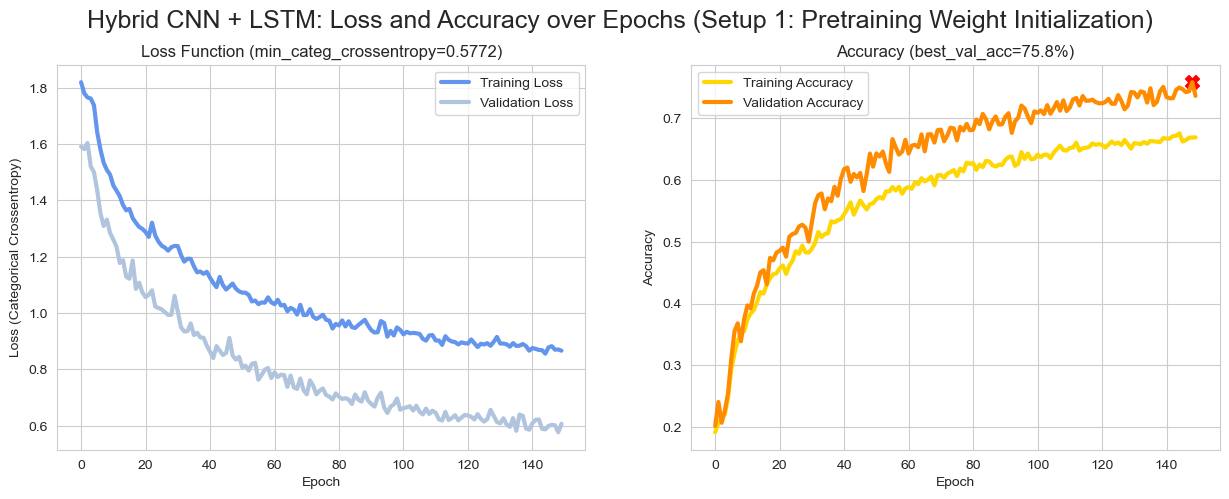

<Figure size 640x480 with 0 Axes>

In [63]:
h = np.load(history_name+'.npy', allow_pickle=True).item()

min_val_categ_crossentropy = round(min(h['val_loss']), 4)
best_val_accuracy = round(max(h['val_accuracy']), 3) * 100

# Find the epoch with the best validation accuracy
best_val_acc_epoch = np.argmax(h['val_accuracy'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Hybrid CNN + LSTM: Loss and Accuracy over Epochs (Setup 1: Pretraining Weight Initialization)', fontsize=18, y=0.99)
ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
ax2.set_title(f'Accuracy (best_val_acc={best_val_accuracy}%)')
ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
ax2.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(h['loss'], color="cornflowerblue", linewidth=3)
ax1.plot(h['val_loss'], color="lightsteelblue", linewidth=3)
ax1.legend(['Training Loss', 'Validation Loss'])
ax2.plot(h['accuracy'], color="gold", linewidth=3)
ax2.plot(h['val_accuracy'], color="darkorange", linewidth=3)
ax2.legend(['Training Accuracy', 'Validation Accuracy'])

# Add a red 'X' mark at the epoch where the best validation accuracy occurs
ax2.scatter(best_val_acc_epoch, h['val_accuracy'][best_val_acc_epoch], color='red', marker='X', s=100)

plt.show()

# Saving the figure with the best validation accuracy mark
plt.savefig(history_name + '.png')

model_name = f'results/val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})_lr[{lr}]_conv1{conv1D_1}_pool1{pool1D_1}_conv2{conv1D_2}_pool2{pool1D_2}_dense1[{dense_1}]_dense2[{dense_2}]_lstm[{lstm_1}]_dense3[{dense_3}]'
plt.savefig(model_name + '.png')

## Serializing Datasets (train and val)

In [64]:
X_train = [] ; y_train = []
X_val = [] ; y_val = []
X_loo = [] ; y_loo = []

for feature, label in train_dataset:
    for i in range(label.shape[0]):
        X_train.append(feature[i])
        y_train.append(label[i])
for feature, label in valid_dataset:
    for i in range(label.shape[0]):
        X_val.append(feature[i])
        y_val.append(label[i])
for feature, label in loo_dataset:
    for i in range(label.shape[0]):
        X_loo.append(feature[i])
        y_loo.append(label[i])

X_train = np.array(X_train) ; y_train = np.array(y_train)
X_val = np.array(X_val) ; y_val = np.array(y_val)
X_loo = np.array(X_loo) ; y_loo = np.array(y_loo)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Score

In [65]:
# Find the filename of the best model saved during training
best_model_filename = max(glob.glob('model1/best_model_epoch_*_val_acc_*.keras'), key=os.path.getctime)
# Load the best model
best_model = load_model(best_model_filename)

In [66]:
def plot_confusion_matrix(x,y,color,title):
    predictions_hot = best_model.predict(x)
    predictions = np.argmax(predictions_hot, axis=1)
    np.set_printoptions(suppress=True)
    print("Some y Predicted\t", predictions[:30])
    y_list = np.argmax(y, axis=1)
    print("Some y Label\t\t", y_list[:30])

    cm = confusion_matrix(y_list, predictions)
    plt.figure(figsize = (15,10))
    ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
    ax.set_title(title+'\n\n')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])
    ax.yaxis.set_ticklabels(['TA', 'MG', 'SOL', 'BF', 'ST', 'VL', 'RF'])
    
    np.set_printoptions(precision=3)
    precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
    f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')

    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'fscore: {f1}')
    print(f'fscore_micro: {f1_micro:.3f}')

    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.show()
    
    return precision, recall, f1, f1_micro

## Confusion Matrix in Training

757/757 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Some y Predicted	 [0 2 1 5 4 3 2 3 5 1 2 6 2 3 1 5 3 4 2 2 4 5 2 0 0 1 2 1 3 6]
Some y Label		 [1 2 1 5 4 3 2 3 5 1 3 5 2 3 1 5 3 1 2 2 3 5 2 0 0 1 2 1 3 6]
precision: [0.851 0.82  0.768 0.851 0.596 0.738 0.702]
recall: [0.86  0.839 0.807 0.76  0.744 0.782 0.44 ]
fscore: [0.855 0.829 0.787 0.803 0.662 0.759 0.541]
fscore_micro: 0.7583801188903568


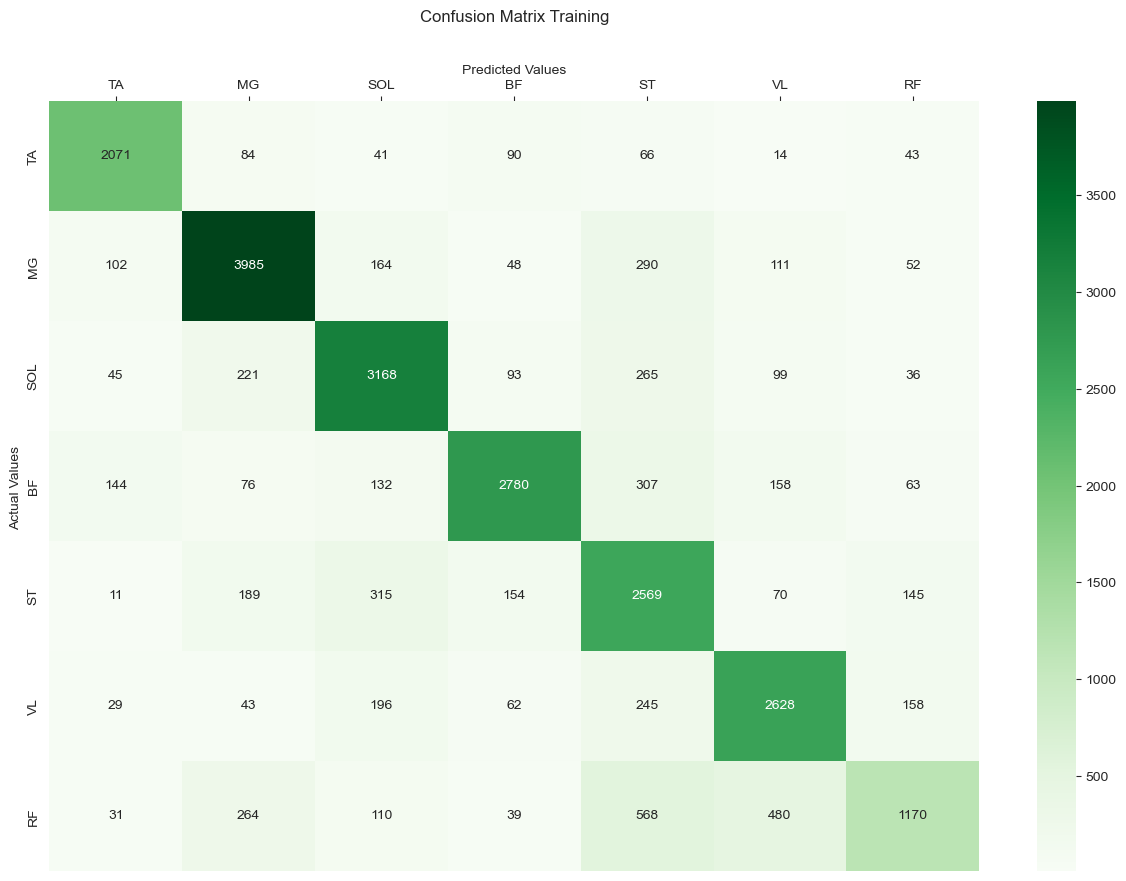

(array([0.851, 0.82 , 0.768, 0.851, 0.596, 0.738, 0.702]),
 array([0.86 , 0.839, 0.807, 0.76 , 0.744, 0.782, 0.44 ]),
 array([0.855, 0.829, 0.787, 0.803, 0.662, 0.759, 0.541]),
 0.7583801188903568)

In [67]:
plot_confusion_matrix(X_train, y_train, 'Greens', 'Confusion Matrix Training')

## Confusion Matrix in Testing

190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Some y Predicted	 [3 5 2 3 2 1 5 0 4 0 1 0 5 1 6 2 4 4 4 5 1 4 4 3 5 0 2 4 5 4]
Some y Label		 [3 5 2 3 2 1 5 0 6 0 1 0 5 1 6 2 3 3 4 5 1 2 6 3 6 5 2 4 5 4]
precision: [0.859 0.807 0.783 0.86  0.594 0.727 0.709]
recall: [0.853 0.829 0.793 0.776 0.747 0.798 0.442]
fscore: [0.856 0.818 0.788 0.816 0.662 0.761 0.545]
fscore_micro: 0.7582508250825083


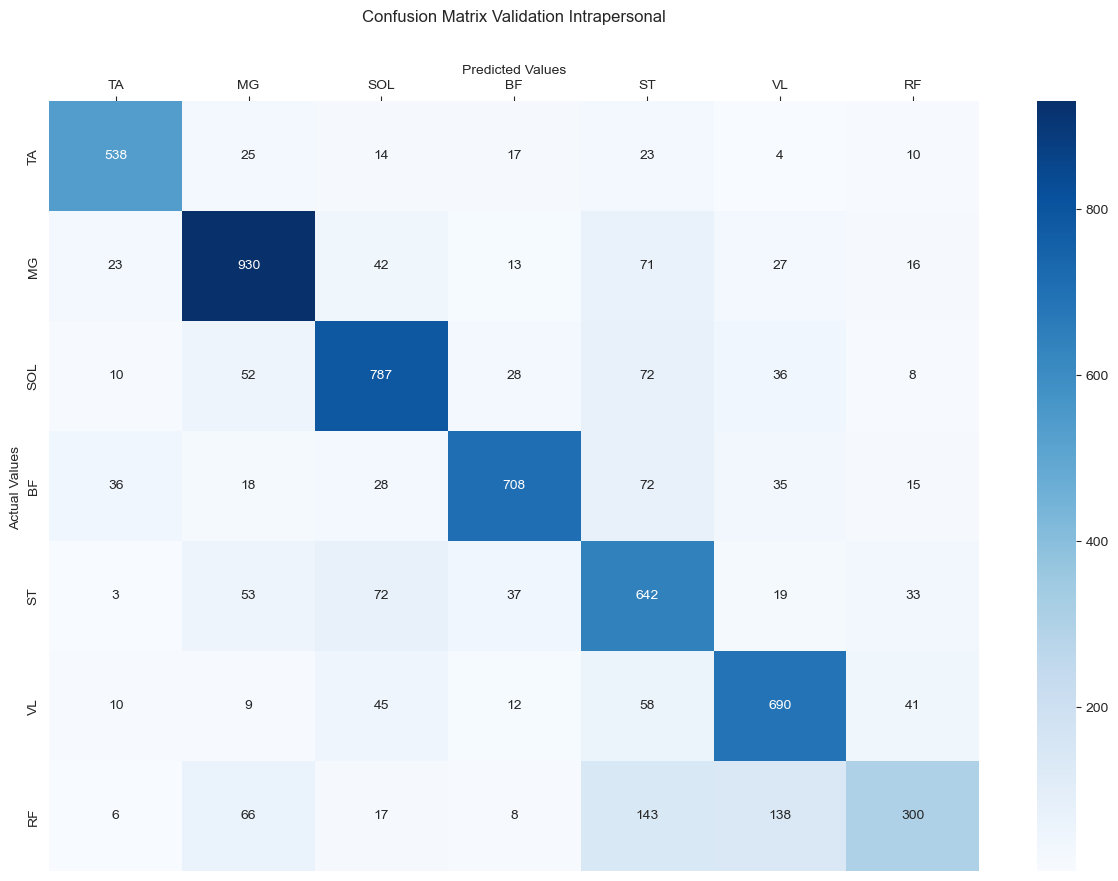

In [68]:
testing_precision, testing_recall, testing_f1, testing_f1_micro  = plot_confusion_matrix(X_val, y_val, 'Blues', 'Confusion Matrix Validation Intrapersonal')

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Some y Predicted	 [6 1 3 1 0 2 6 2 3 4 6 2 1 2 2 2 1 2 1 2 2 3 6 3 0 2 2 2 0 3]
Some y Label		 [5 0 3 1 1 2 3 5 4 3 6 4 0 5 3 4 1 3 0 3 3 4 5 3 0 2 2 3 1 4]
precision: [0.073 0.372 0.419 0.184 0.07  0.743 0.308]
recall: [0.104 0.308 0.925 0.205 0.023 0.207 0.32 ]
fscore: [0.085 0.337 0.577 0.194 0.035 0.323 0.314]
fscore_micro: 0.31238140417457305


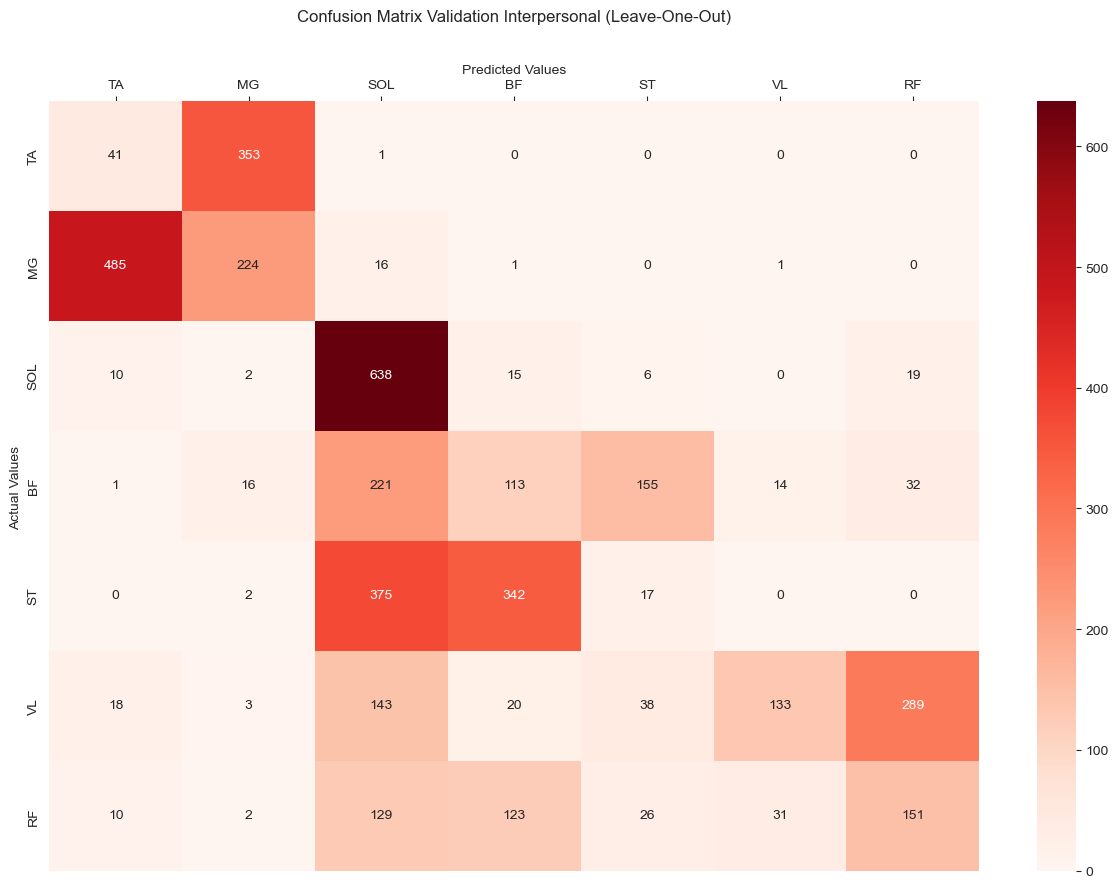

In [69]:
interpersonal_precision, interpersonal_recall, interpersonal_f1, interpersonal_f1_micro = plot_confusion_matrix(X_loo, y_loo, 'Reds', 'Confusion Matrix Validation Interpersonal (Leave-One-Out)')

In [70]:
# Log the best validation accuracy and loss
wandb.log({"testing_f1": testing_f1, "testing_f1_micro": testing_f1_micro,
           "testing_precision": testing_precision, "testing_recall": testing_recall,
           "interpersonal_f1": interpersonal_f1, "interpersonal_f1_micro": interpersonal_f1_micro,
           "interpersonal_precision": interpersonal_precision, "interpersonal_recall": interpersonal_recall})

wandb.finish()

batch/accuracy,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/loss,██▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best_val_accuracy,▁
epoch/accuracy,▁▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/loss,██▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▃▃▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
epoch/val_loss,██▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
interpersonal_f1_micro,▁
min_val_loss,▁
